In [1]:
# ================================================================
# 01_preprocess.py  –  Pré-processamento diário (versão peso em gramas)
# ------------------------------------------------------------
# Este script lê o arquivo Excel `datasets/dados.xlsx`, aplica
# validações robustas, trata outliers e gera os 15 indicadores
# diários exigidos pelo projeto. Agora o peso é convertido de kg
# para gramas (`peso_g`). As razões por kg continuam corretas ao
# dividir `peso_g` por 1 000.
# ------------------------------------------------------------
# Como usar (terminal macOS, já com venv ativo):
#   python src/01_preprocess.py
# ------------------------------------------------------------
# Requisitos: pandas, numpy, pyarrow, openpyxl, tqdm (opcional)
# Instalação sugerida (brew + pip):
#   brew install pyarrow
#   pip install pandas numpy openpyxl tqdm
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Configurações básicas
# -----------------------------------------------------------------

DATA_PATH = Path("datasets") / "dados.xlsx"  # input
OUTPUT_PATH = Path("datasets") / "dados_diarios_preproc.parquet"  # output

# Colunas mínimas que o pipeline não pode rodar sem
REQUIRED_COLS = {
    "data", "peso_kg",
    "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade",
    "passos", "minutos_em_pe",
    "fc_repouso_bpm", "hrv_medio",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Colunas que não podem ter valores negativos
NON_NEGATIVE = {
    "peso_kg", "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade", "passos", "minutos_em_pe",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Quantis usados para winsorização
QUANT_LOW, QUANT_HIGH = 0.05, 0.95

# -----------------------------------------------------------------
# 2. Funções utilitárias
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê o Excel, normaliza nomes de colunas e remove duplicatas.

    - `strip()` espaços iniciais/finais
    - converte a `snake_case` mínima (lower)
    - se nomes repetirem, mantém somente a primeira ocorrência
    """
    df = pd.read_excel(path, engine="openpyxl")

    # normaliza cabeçalhos
    new_cols = []
    seen = set()
    for raw in df.columns:
        col = str(raw).strip()
        col = col.replace(" ", "_").lower()
        if col in seen:
            warnings.warn(
                f"Coluna duplicada encontrada e ignorada: '{col}'. Somente a primeira ocorrência será usada.",
                RuntimeWarning,
            )
            continue
        new_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = new_cols
    return df


def winsorize(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Aplica winsorização p5–p95 inplace para as colunas fornecidas."""
    for col in tqdm(cols, desc="Winsorizando", leave=False):
        lo, hi = df[col].quantile([QUANT_LOW, QUANT_HIGH], interpolation="linear")
        df[col] = df[col].clip(lo, hi)
    return df

# -----------------------------------------------------------------
# 3. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not DATA_PATH.exists():
        sys.exit(f"❌ Arquivo de dados não encontrado em {DATA_PATH.resolve()}")

    print("📥  Lendo planilha…")
    df = read_excel_unique(DATA_PATH)

    # ----- validação de colunas essenciais -----
    missing = sorted(REQUIRED_COLS - set(df.columns))
    if missing:
        sys.exit(f"❌ Faltando colunas obrigatórias: {missing}")

    # ----- normalização de tipos & valores impossíveis -----
    print("🧹  Ajustando tipos e valores…")
    df["data"] = pd.to_datetime(df["data"], errors="coerce")

    for col in NON_NEGATIVE & set(df.columns):
        df.loc[df[col] < 0, col] = np.nan

    # ----- converte peso para gramas e remove peso_kg -----
    df["peso_g"] = df["peso_kg"] * 1000.0  # precisão em gramas
    df.drop(columns="peso_kg", inplace=True)

    # ----- winsorização p5–p95 -----
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    winsorize(df, numeric_cols)

    # -----------------------------------------------------------------
    # 4. Cálculo dos indicadores
    # -----------------------------------------------------------------
    print("🧮  Calculando indicadores…")

    df_ind = pd.DataFrame()
    df_ind["data"] = df["data"]

    # cópias diretas
    df_ind["Fat_pct_mean"]          = df["gordura_pct"]
    df_ind["Circumference_cm_med"] = df["circunferencia_cm"]
    df_ind["Total_kcal_mean"]       = df["energia_total"]
    df_ind["Steps_mean"]            = df["passos"]
    df_ind["RestingHR_mean"]        = df["fc_repouso_bpm"]
    df_ind["HRV_mean"]              = df["hrv_medio"]
    df_ind["SleepDur_mean"]         = df["duracao_sono_min"]
    df_ind["Water_ml_mean"]         = df["agua_consumida_ml"]

    # derivadas / razões
    df_ind["Lean_to_Fat_ratio"]       = df["massa_magra_pct"] / df["gordura_pct"]
    df_ind["Activity_kcal_fraction"]  = df["energia_atividade"] / df["energia_total"]
    df_ind["Standing_minutes_raw"]    = df["minutos_em_pe"]  # para desvio-padrão futuro
    df_ind["DeepFrac_mean"]           = df["minutos_deep"] / df["duracao_sono_min"]

    # razões por kg – dividimos peso em gramas por 1000
    kg_denominator = df["peso_g"] / 1000.0
    df_ind["Carb_per_kg_mean"]        = df["carboidratos_g"] / kg_denominator
    df_ind["Protein_per_kg_mean"]     = df["proteinas_g"] / kg_denominator

    # déficit calórico permanece igual
    df_ind["Cal_deficit_mean"]        = df["calorias_consumidas"] - df["energia_total"]

    # ----- salva parquet -----
    print("💾  Gravando Parquet…")
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_ind.sort_values("data").to_parquet(OUTPUT_PATH, index=False, engine="pyarrow")

    # resumo rápido
    print("\n✅  Pré-processamento concluído!")
    print(f"Arquivo salvo em: {OUTPUT_PATH.resolve()}")
    print("\nResumo numérico (pós-winsor):")
    print(df_ind.describe().loc[["mean", "std", "min", "max"]].round(2))


if __name__ == "__main__":
    main()


📥  Lendo planilha…
🧹  Ajustando tipos e valores…


🧮  Calculando indicadores…
💾  Gravando Parquet…

✅  Pré-processamento concluído!
Arquivo salvo em: /Users/luc/Documents/TCC v2/datasets/dados_diarios_preproc.parquet

Resumo numérico (pós-winsor):
                     data  Fat_pct_mean  Circumference_cm_med  \
mean  2026-05-15 12:00:00         20.04                 79.93   
std                   NaN          1.78                  4.43   
min   2025-01-01 00:00:00         16.90                 72.09   
max   2027-09-27 00:00:00         23.30                 88.10   

      Total_kcal_mean  Steps_mean  RestingHR_mean  HRV_mean  SleepDur_mean  \
mean          2002.13     7453.53           62.05     50.13         481.06   
std            112.16     2510.73            4.34      8.70          23.26   
min           1800.95     3514.00           55.00     35.20         441.00   
max           2213.10    11471.70           69.00     66.20         523.00   

      Water_ml_mean  Lean_to_Fat_ratio  Activity_kcal_fraction  \
mean        2241.66 

WIndows cons

In [2]:
# ================================================================
# 02_window_construction.py – Construção das janelas de 91 dias
# ------------------------------------------------------------
# Pipeline comentado linha a linha:
#   1. Lê o parquet diário com 15 indicadores + peso em gramas.
#   2. Anexa o peso (g) para cada dia a partir do Excel.
#   3. Desliza janelas de 91 dias (step = 7).
#   4. Agrega indicadores (média, mediana, desvio‑padrão).
#   5. Calcula o alvo: inclinação da reta peso × tempo (kg/sem).
#   6. Salva o resultado em Parquet para uso no BSTS.
# ------------------------------------------------------------
# Execução (terminal macOS):
#   python src/02_window_construction.py
# ------------------------------------------------------------
# Dependências: pandas, numpy, pyarrow, openpyxl, tqdm
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Caminhos e parâmetros
# -----------------------------------------------------------------

DAILY_PARQUET = Path("datasets") / "dados_diarios_preproc.parquet"
EXCEL_SOURCE = Path("datasets") / "dados.xlsx"
WINDOW_PARQUET = Path("datasets") / "janelas_91d.parquet"

WINDOW_SIZE = 91   # dias na janela
STEP_SIZE = 7      # deslocamento

# -----------------------------------------------------------------
# 2. Leitura defensiva do Excel (sem colunas duplicadas)
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê Excel, normaliza cabeçalhos e descarta colunas duplicadas."""
    df = pd.read_excel(path, engine="openpyxl")

    norm_cols, seen = [], set()
    for raw in df.columns:
        col = str(raw).strip().replace(" ", "_").lower()
        if col in seen:
            warnings.warn(f"Coluna duplicada ignorada: {col}")
            continue
        norm_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = norm_cols
    return df

# -----------------------------------------------------------------
# 3. Funções de agregação por janela
# -----------------------------------------------------------------

def slope_kg_per_week(sub: pd.DataFrame) -> float:
    """Inclinação da reta de peso (kg/semana) dentro de uma janela."""
    y = sub["peso_g"].values / 1000.0  # g → kg
    if np.isnan(y).any():
        return np.nan
    x = np.arange(len(sub))            # 0..90
    slope_day = np.polyfit(x, y, 1)[0] # kg/dia
    return slope_day * 7               # kg/semana


def aggregate_window(sub: pd.DataFrame) -> dict:
    """Calcula métricas da janela (mean, median, std) + alvo."""
    out: dict[str, float] = {}

    # --- médias (11) ---
    mean_cols = {
        "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
        "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
        "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    }
    for c in mean_cols:
        out[c] = sub[c].mean()

    # --- mediana (1) ---
    out["Circumference_cm_med"] = sub["Circumference_cm_med"].median()

    # --- desvio‑padrão (1) ---
    out["Standing_variability"] = sub["Standing_minutes_raw"].std()

    # --- razões por kg (2) ---
    out["Carb_per_kg_mean"]    = sub["Carb_per_kg_mean"].mean()
    out["Protein_per_kg_mean"] = sub["Protein_per_kg_mean"].mean()

    # --- alvo ---
    out["slope_kg_per_week"] = slope_kg_per_week(sub)
    return out


def generate_windows(df: pd.DataFrame) -> pd.DataFrame:
    """Gera DataFrame final: 1 linha por janela deslizante."""
    records = []
    starts = range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE)
    for i in tqdm(starts, desc="Gerando janelas"):
        sub = df.iloc[i : i + WINDOW_SIZE]
        rec = aggregate_window(sub)
        rec["window_start"] = sub["data"].iloc[0]
        records.append(rec)
    return pd.DataFrame(records)

# -----------------------------------------------------------------
# 4. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    # 4.1 Carrega indicadores diários
    if not DAILY_PARQUET.exists():
        sys.exit("❌ Parquet diário não encontrado. Rode 01_preprocess.py primeiro.")
    df_ind = pd.read_parquet(DAILY_PARQUET)

    # 4.2 Anexa peso (g)
    df_weight = read_excel_unique(EXCEL_SOURCE)[["data", "peso_kg"]]
    df_weight["data"] = pd.to_datetime(df_weight["data"], errors="coerce")
    df_weight["peso_g"] = df_weight["peso_kg"] * 1000.0

    # merge (inner) – remove datas sem indicador ou sem peso
    df_full = (
        df_ind.merge(df_weight[["data", "peso_g"]], on="data", how="inner")
               .sort_values("data")
               .reset_index(drop=True)
    )

    # 4.3 Gera janelas
    df_windows = generate_windows(df_full)

    # 4.4 Salva
    WINDOW_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_windows.to_parquet(WINDOW_PARQUET, index=False, engine="pyarrow")

    # 4.5 Resumo
    print("✅  Janelas salvas em:", WINDOW_PARQUET.resolve())
    print("Total de janelas:", len(df_windows))
    print(df_windows.head())


if __name__ == "__main__":
    main()


Gerando janelas: 100%|██████████| 130/130 [00:00<00:00, 3015.75it/s]

✅  Janelas salvas em: /Users/luc/Documents/TCC v2/datasets/janelas_91d.parquet
Total de janelas: 130
   Total_kcal_mean  Water_ml_mean   Steps_mean  Activity_kcal_fraction  \
0      1995.100549    2178.089560  7723.165934                0.299358   
1      1991.165934    2184.254945  7671.605495                0.300560   
2      1996.847253    2178.802747  7712.385714                0.301069   
3      1997.486264    2182.385165  7870.154945                0.301059   
4      1991.507143    2196.855495  7917.352747                0.298900   

   DeepFrac_mean  Cal_deficit_mean  SleepDur_mean  Lean_to_Fat_ratio  \
0       0.300193       -798.222527     480.945055           3.764655   
1       0.300173       -803.310989     481.340659           3.761750   
2       0.300144       -818.147802     481.274725           3.795185   
3       0.300093       -814.224725     482.087912           3.809480   
4       0.300091       -802.893407     482.824176           3.826643   

   RestingHR_mean   H

Correlação

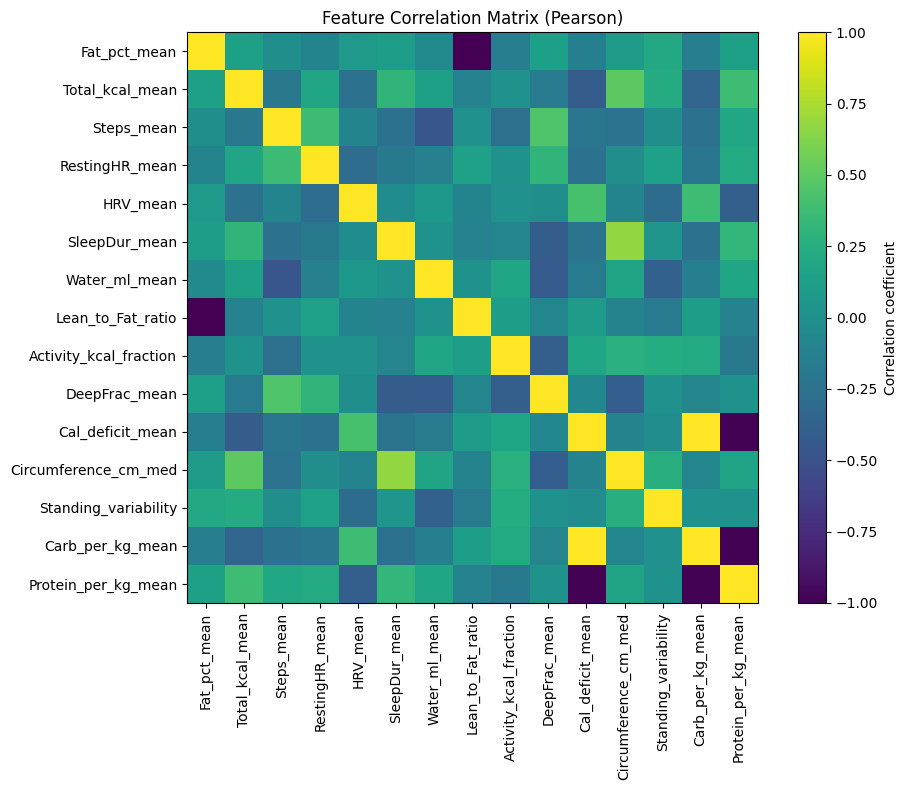

,var1,var2,corr
0,Fat_pct_mean,Lean_to_Fat_ratio,-0.994326
1,Cal_deficit_mean,Carb_per_kg_mean,0.994319
2,Carb_per_kg_mean,Protein_per_kg_mean,-0.988365
3,Cal_deficit_mean,Protein_per_kg_mean,-0.985024


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display

# --- 1. Load the windows data ---
df_windows = pd.read_parquet("datasets/janelas_91d.parquet")

# --- 2. Select feature columns ---
feature_cols = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean"
]
X = df_windows[feature_cols]

# --- 3. Correlation matrix ---
corr_matrix = X.corr()

# --- 4. Heatmap (agora com viridis) ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, cmap="viridis")  # ← aqui
ax.set_xticks(range(len(feature_cols)))
ax.set_yticks(range(len(feature_cols)))
ax.set_xticklabels(feature_cols, rotation=90)
ax.set_yticklabels(feature_cols)
ax.set_title("Feature Correlation Matrix (Pearson)")
plt.colorbar(im, ax=ax, label="Correlation coefficient")
plt.tight_layout()
plt.show()

# --- 5. Pairs with |corr| ≥ 0.80 ---
threshold = 0.80
rows = [
    {"var1": feature_cols[i], "var2": feature_cols[j], "corr": corr_matrix.iat[i, j]}
    for i, j in combinations(range(len(feature_cols)), 2)
    if abs(corr_matrix.iat[i, j]) >= threshold
]
high_corr_df = (pd.DataFrame(rows)
                .sort_values("corr", key=np.abs, ascending=False)
                .reset_index(drop=True))

display(high_corr_df)


Tratamento da colinearidade

In [4]:
# ================================================================
# 03_collinearity_filter_v3.py – Colinearidade + estatísticas do slope
# --------------------------------------------------------------------
# • Agrupa variáveis com |ρ| ≥ 0.80 (Pearson) e resolve colinearidade
#   (menor média |ρ| interna, desempate pelo maior |corr(X, y)|).
# • Exibe no relatório, para **cada** variável (mantida ou eliminada):
#     – média |ρ| interna no grupo
#     – |corr(X, slope_kg_per_week)|  (força preditiva univariada)
# • Salva Parquet filtrado + .txt das eliminadas (com estatísticas).
# --------------------------------------------------------------------
# Execução:  python src/03_collinearity_filter_v3.py
# Dependências: pandas, numpy, pyarrow, networkx
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

# -----------------------------------------------------------------
# Caminhos e parâmetros
# -----------------------------------------------------------------
WINDOW_PARQUET = Path("datasets") / "janelas_91d.parquet"
FILTERED_PARQUET = Path("datasets") / "janelas_91d_filtered.parquet"
REMOVED_TXT = Path("datasets") / "janelas_91d_removed_cols.txt"

THRESHOLD = 0.80  # |ρ| limiar

FEATURE_COLS = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean",
]

TARGET_COL = "slope_kg_per_week"
DATE_COL = "window_start"

# -----------------------------------------------------------------
# Utilitários
# -----------------------------------------------------------------

def build_graph(corr: pd.DataFrame, cols: list[str], thr: float) -> nx.Graph:
    g = nx.Graph()
    g.add_nodes_from(cols)
    for i, c1 in enumerate(cols):
        for c2 in cols[i + 1 :]:
            if abs(corr.loc[c1, c2]) >= thr:
                g.add_edge(c1, c2)
    return g


def pick_keep_column(group: list[str], corr: pd.DataFrame, y_corr: pd.Series) -> str:
    """Menor média |ρ| interna; desempate por maior |corr(X, y)|."""
    mean_r = {
        col: np.mean([abs(corr.loc[col, other]) for other in group if other != col])
        for col in group
    }
    min_mean = min(mean_r.values())
    candidates = [c for c, m in mean_r.items() if np.isclose(m, min_mean)]
    if len(candidates) == 1:
        return candidates[0]
    return max(candidates, key=lambda c: abs(y_corr[c]))

# -----------------------------------------------------------------
# Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not WINDOW_PARQUET.exists():
        sys.exit("❌ Arquivo de janelas não encontrado.")

    df = pd.read_parquet(WINDOW_PARQUET)
    X = df[FEATURE_COLS]
    y = df[TARGET_COL]

    corr = X.corr()
    y_corr = X.apply(lambda col: col.corr(y))  # Series de correlação com y

    graph = build_graph(corr, FEATURE_COLS, THRESHOLD)
    groups = list(nx.connected_components(graph))

    kept, removed_info = [], []
    for grp in groups:
        grp_list = sorted(grp, key=lambda c: FEATURE_COLS.index(c))
        if len(grp_list) == 1:
            kept.append(grp_list[0])
            continue
        keep_col = pick_keep_column(grp_list, corr, y_corr)
        kept.append(keep_col)
        for col in grp_list:
            if col == keep_col:
                continue
            mean_internal = np.mean([abs(corr.loc[col, other]) for other in grp_list if other != col])
            removed_info.append((col, mean_internal, abs(y_corr[col])))

    # Ordena pelo índice original
    kept.sort(key=lambda c: FEATURE_COLS.index(c))
    removed_info.sort(key=lambda t: FEATURE_COLS.index(t[0]))

    # --- Relatório ---
    print("Mantidas (", len(kept), ") – estatísticas:")
    for col in kept:
        # média |ρ| dentro do grupo se houver conexão; caso contrário, NaN → "—"
        internal_vals = [abs(corr.loc[col, other]) for other in FEATURE_COLS if other != col and abs(corr.loc[col, other]) >= THRESHOLD]
        mean_int = np.mean(internal_vals) if internal_vals else np.nan
        mean_text = f"{mean_int:.3f}" if not np.isnan(mean_int) else "—"
        print(f"  {col:<25} média|ρ_grupo|={mean_text:<5}  |ρ(col,y)|={abs(y_corr[col]):.3f}")

    print("\nEliminadas (", len(removed_info), ") – média|ρ| e |ρ(col,y)|:")
    for col, m_int, rho_y in removed_info:
        print(f"  {col:<25} {m_int:.3f} {rho_y:.3f}")

    # Salva arquivos
    df[kept + [TARGET_COL, DATE_COL]].to_parquet(FILTERED_PARQUET, index=False, engine="pyarrow")
    with REMOVED_TXT.open("w") as f:
        for col, m_int, rho_y in removed_info:
            f.write(f"{col}\t{m_int:.3f}\t{rho_y:.3f}\n")

    print("\n✅ Parquet filtrado salvo em:", FILTERED_PARQUET.resolve())
    print("Lista detalhada em:", REMOVED_TXT.resolve())


if __name__ == "__main__":
    main()


Mantidas ( 12 ) – estatísticas:
  Fat_pct_mean              média|ρ_grupo|=0.994  |ρ(col,y)|=0.169
  Total_kcal_mean           média|ρ_grupo|=—      |ρ(col,y)|=0.347
  Steps_mean                média|ρ_grupo|=—      |ρ(col,y)|=0.336
  RestingHR_mean            média|ρ_grupo|=—      |ρ(col,y)|=0.127
  HRV_mean                  média|ρ_grupo|=—      |ρ(col,y)|=0.024
  SleepDur_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.099
  Water_ml_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.451
  Activity_kcal_fraction    média|ρ_grupo|=—      |ρ(col,y)|=0.077
  DeepFrac_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.304
  Circumference_cm_med      média|ρ_grupo|=—      |ρ(col,y)|=0.156
  Standing_variability      média|ρ_grupo|=—      |ρ(col,y)|=0.026
  Protein_per_kg_mean       média|ρ_grupo|=0.987  |ρ(col,y)|=0.068

Eliminadas ( 3 ) – média|ρ| e |ρ(col,y)|:
  Lean_to_Fat_ratio         0.994 0.160
  Cal_deficit_mean          0.990 0.085
  Carb_per_kg_mean          0.991 0.055



Antes e depois (colinearidade)


/var/folders/d9/967dq25s2hj2z0_q3g8cx6h00000gn/T/ipykernel_70016/2007645844.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])


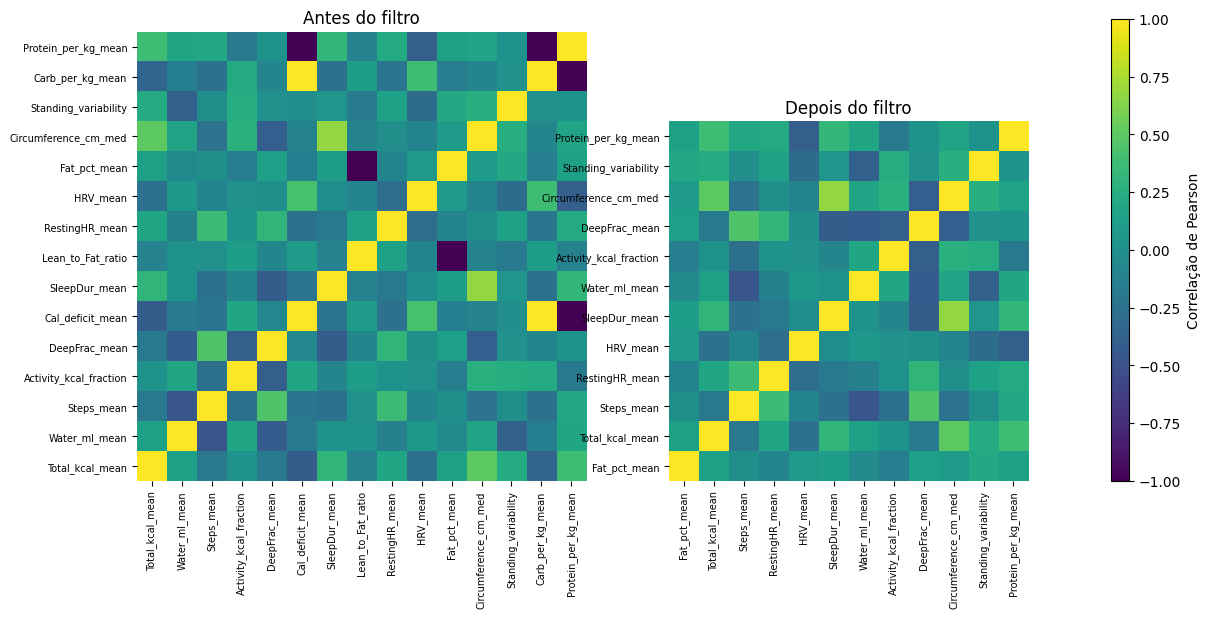

In [5]:
# ================================================================
# Célula: Heat-map de correlações ANTES × DEPOIS (versão 8)
# ----------------------------------------------------------------
# • Quadrículas de tamanho idêntico (aspect="equal") em ambos painéis.
# • Bases alinhadas pelo canto inferior-esquerdo (anchor SW).
# • Painel “Depois” pode ser visualmente menor; espaço vazio aparece
#   acima dele (fundo branco), não há distorção.
# • Colorbar fixa à direita, spines removidos.
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

BEFORE_PATH = "datasets/janelas_91d.parquet"
AFTER_PATH  = "datasets/janelas_91d_filtered.parquet"
TARGET = "slope_kg_per_week"
DATE   = "window_start"

# ---- Load data ----
df_before = pd.read_parquet(BEFORE_PATH)
df_after  = pd.read_parquet(AFTER_PATH)

feat_before = [c for c in df_before.columns if c not in {TARGET, DATE}]
feat_after  = [c for c in df_after.columns  if c not in {TARGET, DATE}]

corr_before = df_before[feat_before].corr()
corr_after  = df_after[feat_after].corr()

n_before = len(feat_before)
n_after  = len(feat_after)

# ---- Figure layout ----
cell = 0.4  # polegadas por célula (tamanho base)
fig_width = cell * (n_before + n_after) + 2  # +2 for colorbar & margins
fig_height = cell * n_before
fig = plt.figure(figsize=(fig_width, fig_height))

# GridSpec: width proportional to #cols, single row
gs = GridSpec(1, 3, width_ratios=[n_before, n_after, 0.6], wspace=0.3)
ax_before = fig.add_subplot(gs[0])
ax_after  = fig.add_subplot(gs[1])
cb_ax     = fig.add_subplot(gs[2])

cmap = mpl.colormaps["viridis"].copy()

# ---- Helper: clean spines/anchor and set aspect ----
for ax in (ax_before, ax_after):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_anchor("SW")
    ax.set_aspect("equal", adjustable="box")

ax_after.set_facecolor("white")

# ---- Plot BEFORE ----
ax_before.imshow(corr_before.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_before.set_xticks(range(n_before))
ax_before.set_yticks(range(n_before))
ax_before.set_xticklabels(feat_before, rotation=90, fontsize=7)
ax_before.set_yticklabels(feat_before, fontsize=7)
ax_before.set_title("Antes do filtro")

# ---- Plot AFTER ----
ax_after.imshow(corr_after.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_after.set_xticks(range(n_after))
ax_after.set_yticks(range(n_after))
ax_after.set_xticklabels(feat_after, rotation=90, fontsize=7)
ax_after.set_yticklabels(feat_after, fontsize=7)
ax_after.set_title("Depois do filtro")

# Align bases – ensured by anchor SW and equal aspect; no extra code

# ---- Colorbar ----
fig.colorbar(ax_before.images[0], cax=cb_ax, label="Correlação de Pearson")
cb_ax.yaxis.set_ticks_position("right")

# ---- Layout ----
fig.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

grafo de colinearidade (network graph)

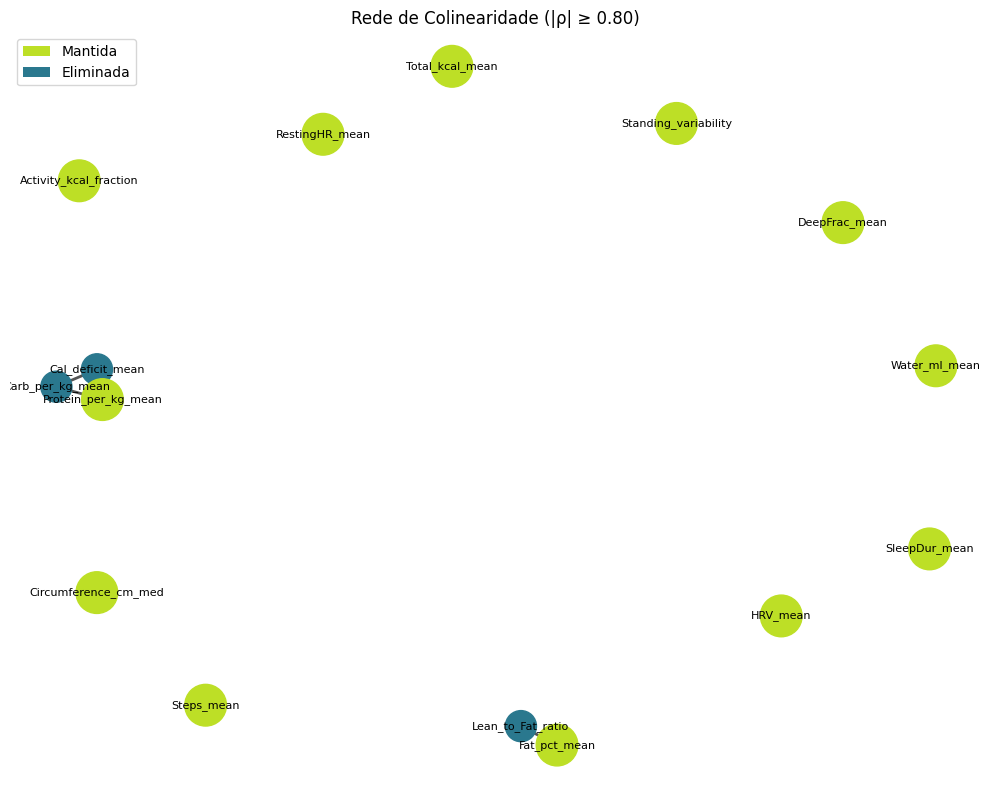

In [6]:
# ================================================================
# Célula: Rede de Colinearidade (versão 2 — viridis + legenda)
# ----------------------------------------------------------------
# • Grafo com variáveis como nós; arestas se |ρ| ≥ 0.80.
# • Paleta **viridis** para consistência visual: nós mantidos = tom
#   escuro, eliminados = tom claro.
# • Legenda adicionada explicando as duas cores.
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from matplotlib.patches import Patch

PARQUET_BEFORE = "datasets/janelas_91d.parquet"
PARQUET_AFTER  = "datasets/janelas_91d_filtered.parquet"
TARGET = "slope_kg_per_week"
DATE   = "window_start"
THRESHOLD = 0.80

# ---- Load datasets ----
df_before = pd.read_parquet(PARQUET_BEFORE)
df_after  = pd.read_parquet(PARQUET_AFTER)

features_all  = [c for c in df_before.columns if c not in {TARGET, DATE}]
features_keep = [c for c in df_after.columns  if c not in {TARGET, DATE}]

corr = df_before[features_all].corr()

# ---- Build graph ----
G = nx.Graph()
G.add_nodes_from(features_all)
for i, c1 in enumerate(features_all):
    for c2 in features_all[i + 1 :]:
        if abs(corr.loc[c1, c2]) >= THRESHOLD:
            G.add_edge(c1, c2, weight=abs(corr.loc[c1, c2]))

# ---- Node styling (viridis) ----
cmap = mpl.colormaps["viridis"]
color_keep = cmap(0.9)   # mais escuro
color_drop = cmap(0.4)   # mais claro
node_colors = [color_keep if n in features_keep else color_drop for n in G.nodes]
node_sizes  = [900 if n in features_keep else 500 for n in G.nodes]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))

# Edges com alpha proporcional ao peso
edge_weights = [G[u][v]['weight'] for u, v in G.edges]
max_w = max(edge_weights) if edge_weights else 1
for (u, v), w in zip(G.edges, edge_weights):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2,
        alpha=w / max_w, edge_color="#555555"
    )

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_labels(G, pos, font_size=8)

# ---- Legend ----
legend_elements = [
    Patch(facecolor=color_keep, edgecolor='none', label='Mantida'),
    Patch(facecolor=color_drop, edgecolor='none', label='Eliminada'),
]
plt.legend(handles=legend_elements, loc="upper left")

plt.title("Rede de Colinearidade (|ρ| ≥ 0.80)")
plt.axis("off")
plt.tight_layout()
plt.show()

Prepare model data

In [7]:
# ================================================================
# 04_prepare_model_data.py – Normalização, split e estatísticas
# ------------------------------------------------------------
# • Carrega janelas filtradas (sem colinearidade).
# • Normaliza via z-score usando médias/desvios do bloco de treino.
# • Divide cronologicamente em treino inicial (70 %) e walk-forward.
# • Salva Parquets + json de scalers.
# • Imprime tabela .describe() das features normalizadas (treino)
#   e resumo do alvo slope_kg_per_week (treino vs. walk).
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd

FILTERED_PARQUET = Path("datasets") / "janelas_91d_filtered.parquet"
TRAIN_PARQUET    = Path("datasets") / "train_initial.parquet"
WALK_PARQUET     = Path("datasets") / "walk_forward.parquet"
SCALER_JSON      = Path("datasets") / "feature_scalers.json"

TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"
TRAIN_FRAC = 0.70  # 70 % janelas mais antigas → treino inicial

# -----------------------------------------------------------------
# Pipeline
# -----------------------------------------------------------------

def main() -> None:
    if not FILTERED_PARQUET.exists():
        sys.exit("❌ Parquet filtrado não encontrado. Rode o filtro de colinearidade.")

    df = pd.read_parquet(FILTERED_PARQUET).sort_values(DATE_COL).reset_index(drop=True)
    feature_cols = [c for c in df.columns if c not in {TARGET_COL, DATE_COL}]

    # ---- Split temporal ----
    split_idx = int(len(df) * TRAIN_FRAC)
    df_train = df.iloc[:split_idx].copy()
    df_walk  = df.iloc[split_idx:].copy()

    # ---- Compute scalers on train ----
    means = df_train[feature_cols].mean()
    stds  = df_train[feature_cols].std(ddof=0)

    # save scalers
    SCALER_JSON.write_text(json.dumps({"mean": means.to_dict(), "std": stds.to_dict()}, indent=2))

    # ---- Apply z-score ----
    for col in feature_cols:
        df_train[col] = (df_train[col] - means[col]) / stds[col]
        df_walk[col]  = (df_walk[col]  - means[col]) / stds[col]

    # ---- Save Parquets ----
    TRAIN_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_train.to_parquet(TRAIN_PARQUET, index=False, engine="pyarrow")
    df_walk.to_parquet(WALK_PARQUET,  index=False, engine="pyarrow")

    # ---- Report ----
    print("✅ Dados preparados:")
    print(f"  Treino inicial : {len(df_train)} janelas → {TRAIN_PARQUET}")
    print(f"  Walk-forward   : {len(df_walk)} janelas → {WALK_PARQUET}")
    print("  Escalers salvos em:", SCALER_JSON)

    # ---- Extra stats ----
    print("\n### Estatísticas das features normalizadas (treino)\n")
    print(df_train[feature_cols].describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

    print("\n### Resumo do alvo slope_kg_per_week\n")
    for name, dset in {"Treino": df_train, "Walk": df_walk}.items():
        s = dset[TARGET_COL]
        print(f"{name:<7} → média: {s.mean():.3f}  desvio: {s.std():.3f}  min: {s.min():.3f}  max: {s.max():.3f}")


if __name__ == "__main__":
    main()

✅ Dados preparados:
  Treino inicial : 91 janelas → datasets/train_initial.parquet
  Walk-forward   : 39 janelas → datasets/walk_forward.parquet
  Escalers salvos em: datasets/feature_scalers.json

### Estatísticas das features normalizadas (treino)

                        mean    std    min    25%    50%    75%    max
Fat_pct_mean             0.0  1.006 -2.331 -0.781  0.058  0.801  2.273
Total_kcal_mean         -0.0  1.006 -1.826 -0.927  0.063  0.913  1.971
Steps_mean              -0.0  1.006 -2.013 -0.844  0.021  0.837  1.963
RestingHR_mean           0.0  1.006 -2.515 -0.726  0.063  0.697  2.063
HRV_mean                -0.0  1.006 -2.038 -0.763 -0.205  0.823  2.122
SleepDur_mean           -0.0  1.006 -1.770 -0.923 -0.049  0.847  2.247
Water_ml_mean           -0.0  1.006 -1.670 -0.735 -0.151  0.650  2.775
Activity_kcal_fraction   0.0  1.006 -1.623 -0.702 -0.111  0.609  2.606
DeepFrac_mean            0.0  1.006 -2.125 -0.550 -0.145  0.537  2.750
Circumference_cm_med     0.0  1.006 -1.

# Model

Bsts Step1 Define Model

In [8]:
# ================================================================
# 05_define_bsts_model.py – Passo 1: Estrutura do BSTS em TFP
# ----------------------------------------------------------------
# • Carrega train_initial.parquet (features normalizadas + target).
# • Define componentes (tendência local + regressão exógena).
# • Agrupa índices de features para priors hierárquicos.
# • **Adição**: barra de progresso (tqdm) enquanto mapeia os grupos.
# ================================================================
import os
# — coloque estas três linhas antes de qualquer import TensorFlow —
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # força CPU

import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from pathlib import Path
from tqdm import tqdm  # barra de progresso

# --- Config paths ---
TRAIN_PARQUET = Path("datasets") / "train_initial.parquet"
TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"

# --- Load data ---
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]

# Convert to tensors
observed_time_series = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
exog_regressors = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# --- Component 1: Local Linear Trend ---
trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)

# --- Component 2: Exogenous Regression ---
regression = tfp.sts.LinearRegression(design_matrix=exog_regressors, name="ExogenousRegs")

# --- Build model ---
model = tfp.sts.Sum(components=[trend, regression], observed_time_series=observed_time_series)

print("Modelo BSTS definido com:")
print(" • Tendência local")
print(f" • Regressão exógena com {len(feature_cols)} features")
print("Componentes prontos para receber priors hierárquicos no Passo 2.")

# --- Save feature groups for priors ---
feature_groups = {
    "comp_corporal": ["Fat_pct_mean", "Lean_to_Fat_ratio", "Circumference_cm_med"],
    "gasto_energetico": ["Total_kcal_mean", "Activity_kcal_fraction"],
    "atividade": ["Steps_mean", "Standing_variability"],
    "cardio": ["RestingHR_mean", "HRV_mean"],
    "sono": ["SleepDur_mean", "DeepFrac_mean"],
    "nutrientes": ["Carb_per_kg_mean", "Protein_per_kg_mean"],
    "ingestao_hidratacao": ["Cal_deficit_mean", "Water_ml_mean"],
}

print("Mapeando índices de features por grupo…")
# Barra de progresso por grupo
group_indices = {}
for g, cols in tqdm(list(feature_groups.items()), desc="Grupos"):
    group_indices[g] = [feature_cols.index(col) for col in cols if col in feature_cols]

GROUPS_JSON = Path("datasets") / "feature_groups.json"
GROUPS_JSON.write_text(pd.Series(group_indices).to_json(indent=2))
print("Mapa de grupos salvo em", GROUPS_JSON)


/Users/luc/Documents/TCC v2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
I0000 00:00:1752086892.397370 11092754 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752086892.397506 11092754 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Modelo BSTS definido com:
 • Tendência local
 • Regressão exógena com 12 features
Componentes prontos para receber priors hierárquicos no Passo 2.
Mapeando índices de features por grupo…


Grupos: 100%|██████████| 7/7 [00:00<00:00, 282308.92it/s]

Mapa de grupos salvo em datasets/feature_groups.json


Set priors

In [9]:
# ================================================================
# 06_set_priors_bsts.py – Passo 2/3-a (Setup com Priors Ajustados)
# ----------------------------------------------------------------
# • Carrega treino normalizado
# • Define priors hierárquicos para coeficientes de regressão
# • Adiciona prior para observation_noise_scale (HalfNormal)
# • Constrói modelo STS = trend + regression + observation noise
# ================================================================

import os
# — Desativa Metal antes de qualquer import TensorFlow —
os.environ["TF_ENABLE_METAL"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"

import json
from pathlib import Path
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

# — Força CPU-only (após importa) —
try:
    tf.config.set_visible_devices([], "GPU")
except RuntimeError:
    pass

# --- Paths & constantes ---
TRAIN_PARQUET = Path("datasets") / "train_initial.parquet"
GROUPS_JSON   = Path("datasets") / "feature_groups.json"
TARGET_COL    = "slope_kg_per_week"
DATE_COL      = "window_start"

# --- Hyper-priors τ por grupo (coef. de regressão) ---
GROUP_SIGMAS = {
    "comp_corporal":        0.07,
    "gasto_energetico":     0.07,
    "atividade":            0.03,
    "cardio":               0.03,
    "sono":                 0.03,
    "nutrientes":           0.05,
    "ingestao_hidratacao":  0.05,
}

# --- Hiper-prior para o ruído de observação (σ_obs) ---
OBS_SIGMA = 0.02  # ajuste conforme cobertura desejada
obs_noise_prior = tfp.distributions.HalfNormal(scale=OBS_SIGMA)

# --- Carrega dados de treino ---
print("📥  Carregando dados de treino…")
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)

# --- Definição dos componentes STS ---
trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)

# --- Priors hierárquicos para regressão ---
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

prior_scales = []
for idx in range(len(feature_cols)):
    grp   = next(g for g, lst in group_indices.items() if idx in lst)
    sigma = GROUP_SIGMAS.get(grp, 0.05)
    tau   = tfp.util.TransformedVariable(
        initial_value=sigma,
        bijector=tfp.bijectors.Softplus(),
        name=f"tau_{grp}"
    )
    prior_scales.append(tau)
prior_scale_values = tf.stack(prior_scales)

regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs"
)

# --- Soma os componentes e impõe prior de ruído de observação ---
model = tfp.sts.Sum(
    components=[trend, regression],
    observation_noise_scale_prior=obs_noise_prior,
    observed_time_series=Y
)

print("✅ Modelo com priors hierárquicos e ruído ajustado – pronto para VI.")


📥  Carregando dados de treino…
✅ Modelo com priors hierárquicos e ruído ajustado – pronto para VI.


Inferencia Variacional 1

In [10]:
# ================================================================
# 07_vi_step3a_setup.py – Inferência Variacional (Setup) – FIXED
# ----------------------------------------------------------------
# • Coloca variáveis de ambiente **antes** do primeiro import TF para
#   desativar backend Metal e suprimir logs.
# • Força CPU‑only após import.
# • Mantém lógica original de seed aleatório, reconstrução do modelo
#   com priors hierárquicos e criação do surrogate posterior.
# ================================================================

# -----------------------------------------------------------------
# 0. Variáveis de ambiente – devem vir ANTES de qualquer import TF
# -----------------------------------------------------------------
import os, random, json, logging
from pathlib import Path

os.environ["TF_ENABLE_METAL"] = "0"            # desativa plugin Metal (GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"      # suprime INFO/WARNING
os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"  # driver Metal

# -----------------------------------------------------------------
# 1. Imports depois das env‑vars
# -----------------------------------------------------------------
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import absl.logging as absl_logging
from tqdm import tqdm

# Supressão de loggers Python/absl
tf.get_logger().setLevel("ERROR")
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging.set_stderrthreshold("error")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ----- Força CPU‑only -----
try:
    tf.config.set_visible_devices([], "GPU")
except Exception:
    pass

# -----------------------------------------------------------------
# 2. Constantes e hiperparâmetros
# -----------------------------------------------------------------
TRAIN_PARQUET = Path("datasets") / "train_initial.parquet"
GROUPS_JSON   = Path("datasets") / "feature_groups.json"
TARGET_COL    = "slope_kg_per_week"
DATE_COL      = "window_start"

NUM_STEPS     = 2000
LEARNING_RATE = 1e-2

# Seed aleatório (impresso para reproducibilidade)
TF_SEED = random.randint(0, 2**32 - 1)
print("Seed usado nesta execução:", TF_SEED)
tf.random.set_seed(TF_SEED)

# -----------------------------------------------------------------
# 3. Carrega dados de treino
# -----------------------------------------------------------------
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# -----------------------------------------------------------------
# 4. Reconstrói modelo com priors hierárquicos (Step 2 logic)
# -----------------------------------------------------------------
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

GROUP_SIGMAS = {
    "comp_corporal": 0.10,
    "gasto_energetico": 0.10,
    "atividade": 0.05,
    "cardio": 0.05,
    "sono": 0.05,
    "nutrientes": 0.07,
    "ingestao_hidratacao": 0.07,
}

trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)
prior_scales = []
for idx in range(len(feature_cols)):
    grp = next(g for g, lst in group_indices.items() if idx in lst)
    sigma = GROUP_SIGMAS.get(grp, 0.05)
    tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=f"tau_{grp}")
    prior_scales.append(tau)
prior_scale_values = tf.stack(prior_scales)

regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs")

model = tfp.sts.Sum([trend, regression], observed_time_series=Y)

# -----------------------------------------------------------------
# 5. Surrogate posterior & optimizer
# -----------------------------------------------------------------
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

print("✅ VI setup pronto – surrogate posterior e optimizer definidos.")
print("Num steps:", NUM_STEPS)

# Expose for Step 3‑b
globals().update({
    "model": model,
    "surrogate_posterior": surrogate_posterior,
    "optimizer": optimizer,
    "Y": Y,
    "NUM_STEPS": NUM_STEPS,
})


Seed usado nesta execução: 3932715658
✅ VI setup pronto – surrogate posterior e optimizer definidos.
Num steps: 2000


Treino

In [11]:
# ================================================================
# 08_vi_step3b_train_fixed.py – Inferência Variacional (Treino)
# ----------------------------------------------------------------
# Versão estável:
# • Desativa backend Metal ANTES do import TF.
# • Força CPU‑only.
# • Usa trace_fn com tf.reduce_mean para converter ELBO tensor → escalar.
# • Salva vetor ELBO.
# ================================================================

# ----- Env vars antes do TF -----
import os
os.environ["TF_ENABLE_METAL"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"

from pathlib import Path
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

# ----- CPU‑only -----
try:
    tf.config.set_visible_devices([], "GPU")
except Exception:
    pass

# ----- Globals vindos do Step 3‑a -----
required = ("model", "surrogate_posterior", "optimizer", "Y", "NUM_STEPS")
missing = [n for n in required if n not in globals()]
if missing:
    raise RuntimeError(f"Execute Step 3‑a primeiro; faltando: {missing}")

ELBO_PATH = Path("datasets") / "vi_elbo.npy"
ELBO_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"🏃  Iniciando VI ({NUM_STEPS} passos, CPU‑only)…")
bar = tqdm(total=NUM_STEPS, desc="VI", unit="step")
loss_list: list[float] = []

# ----- trace_fn seguro -----

def trace_fn(tr):
    # ELBO tensor (sample_size,) → escalar usando tf.reduce_mean
    elbo_scalar = float(tf.reduce_mean(-tr.loss).numpy())
    loss_list.append(elbo_scalar)
    bar.update(1)
    if len(loss_list) % 100 == 0:
        bar.set_postfix({"ELBO": f"{elbo_scalar:.3f}"})
    return tr.loss  # necessário para API, não usado fora

# ----- Fit VI -----
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(observed_time_series=Y).log_prob,
    surrogate_posterior=surrogate_posterior,
    optimizer=optimizer,
    num_steps=NUM_STEPS,
    trace_fn=trace_fn,
    sample_size=1,
)

bar.close()
np.save(ELBO_PATH, np.array(loss_list))
print("✅ VI concluído. ELBO final =", loss_list[-1])
print("Vetor de ELBO salvo em", ELBO_PATH)


🏃  Iniciando VI (2000 passos, CPU‑only)…


VI: 2001step [2:12:19,  3.97s/step, ELBO=109.251]                         

✅ VI concluído. ELBO final = 112.56339263916016
Vetor de ELBO salvo em datasets/vi_elbo.npy


Gráfico ELBO

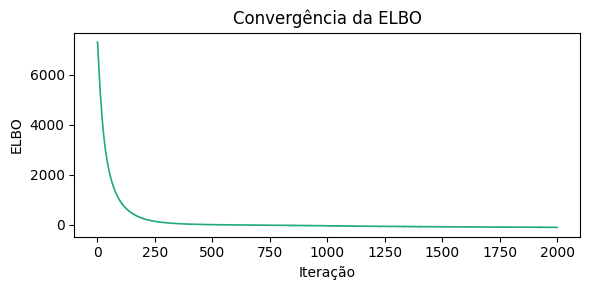

📦  Samplando 1 000 draws da posterior…

── Resumo coeficientes ( 12000 amostras) ─────────────────────
                         mean    std    min    25%    50%    75%    max
Fat_pct_mean            0.005  0.018 -0.082 -0.005  0.004  0.015  0.095
Total_kcal_mean         0.004  0.020 -0.108 -0.006  0.004  0.013  0.123
Steps_mean              0.013  0.023 -0.117  0.001  0.011  0.024  0.143
RestingHR_mean         -0.010  0.019 -0.125 -0.018 -0.008 -0.001  0.094
HRV_mean               -0.005  0.015 -0.086 -0.012 -0.005  0.002  0.111
SleepDur_mean          -0.015  0.025 -0.159 -0.026 -0.014 -0.002  0.127
Water_ml_mean           0.005  0.029 -0.168 -0.011  0.004  0.018  0.165
Activity_kcal_fraction  0.001  0.025 -0.144 -0.009  0.000  0.010  0.152
DeepFrac_mean          -0.002  0.022 -0.157 -0.012 -0.002  0.008  0.147
Circumference_cm_med   -0.004  0.021 -0.115 -0.014 -0.003  0.005  0.128
Standing_variability   -0.002  0.014 -0.080 -0.008 -0.002  0.004  0.083
Protein_per_kg_mean     0.010  0.

In [12]:
# ================================================================
# 09_vi_step3c_diagnostics.py – ELBO & Posterior Diagnostics
# ----------------------------------------------------------------
# • Plota ELBO × iteração (linha viridis).
# • Amostra 1 000 draws da posterior, salva coeficientes e tendência.
# ================================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_probability as tfp

# ----- Checagem -----
assert "surrogate_posterior" in globals(), "Surrogate posterior ausente. Rode 3‑a e 3‑b."
ELBO_PATH = Path("datasets") / "vi_elbo.npy"
assert ELBO_PATH.exists(), "vi_elbo.npy não encontrado. Rode 3‑b."

COEF_PATH  = Path("datasets") / "coef_posterior.parquet"
TREND_PATH = Path("datasets") / "trend_posterior.parquet"

# ----- 1. Plot ELBO -----
losses = np.load(ELBO_PATH)
plt.figure(figsize=(6, 3))
plt.plot(-losses, color=mpl.colormaps.get_cmap("viridis")(0.6), lw=1.2)
plt.xlabel("Iteração")
plt.ylabel("ELBO")
plt.title("Convergência da ELBO")
plt.tight_layout()
plt.show()

# ----- 2. Sample posterior -----
print("📦  Samplando 1 000 draws da posterior…")
samples = surrogate_posterior.sample(1000)

# --- Coeficientes ---
weights = samples["HierLinearRegs/_weights"].numpy()  # possivelmente (1000, chains, feats)
weights = weights.reshape(-1, weights.shape[-1])       # flatten draws×chains → 2‑D

feature_cols = globals().get("feature_cols")
if feature_cols is None:
    df_tmp = pd.read_parquet(Path("datasets") / "train_initial.parquet")
    feature_cols = [c for c in df_tmp.columns if c not in {"slope_kg_per_week", "window_start"}]

coef_df = pd.DataFrame(weights, columns=feature_cols)
coef_df.to_parquet(COEF_PATH, index=False)

# --- Tendência ---
trend_scale = samples["LocalLinearTrend/_level_scale"].numpy().reshape(-1)  # garante 1‑D
pd.DataFrame({"trend_level_scale": trend_scale}).to_parquet(TREND_PATH, index=False)

# ----- 3. Resumo rápido -----
print("\n── Resumo coeficientes (", len(coef_df), "amostras) ─────────────────────")
print(coef_df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

print(f"\nAmostras de coeficientes salvas em: {COEF_PATH}")
print(f"Posterior da tendência salva em: {TREND_PATH}")


Walk forward

In [13]:
# ================================================================
# 10_walk_forward_validation_ic95.py – Passo 4: Walk-Forward
#  com IC95% via stddev preditiva (TFP 0.25.0 compatível)
# ----------------------------------------------------------------
# • Forecast de 1 passo incluindo ruído de observação.
# • Calcula IC95% usando mean() e stddev() da distribuição preditiva.
# ================================================================

from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Enforce CPU-only -----
try:
    tf.config.set_visible_devices([], 'GPU')
except RuntimeError:
    pass  # caso GPU já esteja desativada ou não exista

# ----- Configurações -----
TRAIN_PARQ = Path('datasets') / 'train_initial.parquet'
WALK_PARQ  = Path('datasets') / 'walk_forward.parquet'
PRED_PARQ  = Path('datasets') / 'walk_preds.parquet'
METRICS_JS = Path('datasets') / 'walk_metrics.json'

TARGET = 'slope_kg_per_week'
DATE   = 'window_start'
NUM_DRAWS = 500
Z95 = 1.96  # quantil z para IC95% (p=0.025/0.975)

# ----- Carrega dados -----
df_train0 = pd.read_parquet(TRAIN_PARQ)
df_walk   = pd.read_parquet(WALK_PARQ)
feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]

# ----- Template de tendência e offset -----
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
constant_offset = tf.constant(0.0, dtype=tf.float32)

# ----- Forecast de 1 passo com IC95 -----
def forecast_one_step(y_hist_np: np.ndarray, x_hist_np: np.ndarray, x_future_np: np.ndarray):
    # Converte inputs para float32
    y_hist = y_hist_np.astype(np.float32)
    x_hist = x_hist_np.astype(np.float32)
    x_future = x_future_np.astype(np.float32)

    # Cria design matrix estendido e y extendido
    X_full = np.vstack([x_hist, x_future])  # (T+1, F)
    y_ext = np.concatenate([y_hist, [np.nan]]).astype(np.float32)

    # Componente de regressão e modelo SSM com offset
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )

    # Forecast de 1 passo incluindo ruído de observação
    fc_dist = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior.sample(NUM_DRAWS),
        num_steps_forecast=1,
        include_observation_noise=True
    )

    # Extrai médias condicionais e stddev para cada draw
    means = fc_dist.mean().numpy().reshape(-1)
    stds  = fc_dist.stddev().numpy().reshape(-1)

    # Estatísticas: média pontual e IC95
    mu = float(np.mean(means))
    sd = float(np.mean(stds))
    lo = mu - Z95 * sd
    hi = mu + Z95 * sd

    return mu, lo, hi

# ----- Execução do walk-forward -----
rows = []
df_cum = df_train0.copy()
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Walk-Forward'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]

    mu, lo, hi = forecast_one_step(y_hist, x_hist, x_future)
    rows.append({
        DATE:        row[DATE],
        'pred_mean': mu,
        'pred_lo95':  lo,
        'pred_hi95':  hi,
        'slope_real': float(row[TARGET])
    })
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

# ----- Salva resultados e calcula métricas -----
pred_df = pd.DataFrame(rows)
pred_df.to_parquet(PRED_PARQ, index=False)
mae = float(np.mean(np.abs(pred_df['pred_mean'] - pred_df['slope_real'])))
cover = float(
    np.mean((pred_df['slope_real'] >= pred_df['pred_lo95']) &
            (pred_df['slope_real'] <= pred_df['pred_hi95']))
)
METRICS_JS.write_text(json.dumps({'MAE': mae, 'IC95_coverage': cover}, indent=2))
print(f"✅ Walk-forward concluído. MAE = {mae:.3f} / cobertura95% = {cover*100:.1f}%")


Walk-Forward: 100%|██████████| 39/39 [00:54<00:00,  1.40s/it]

✅ Walk-forward concluído. MAE = 0.021 / cobertura95% = 100.0%


diag


In [14]:
# ================================================================
# 11_calibrate_z_score.py – Calibração do z-score para IC95%
# ----------------------------------------------------------------
# • Executa walk-forward uma vez para obter μ_i e σ_i por janela
# • Varia z em grid e seleciona z que produz cobertura ≈95%
# • Regera predições e métricas finais usando z_calibrado
# ================================================================

from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Enforce CPU-only -----
try:
    tf.config.set_visible_devices([], 'GPU')
except RuntimeError:
    pass

# ----- Configurações -----
TRAIN_PARQ = Path('datasets') / 'train_initial.parquet'
WALK_PARQ  = Path('datasets') / 'walk_forward.parquet'
PRED_PARQ  = Path('datasets') / 'walk_preds_ic95_calibrated.parquet'
METRICS_JS = Path('datasets') / 'walk_metrics_ic95_calibrated.json'

TARGET = 'slope_kg_per_week'
DATE   = 'window_start'
NUM_DRAWS = 500

# ----- Carrega dados -----
df_train0 = pd.read_parquet(TRAIN_PARQ)
df_walk   = pd.read_parquet(WALK_PARQ)
feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]

# ----- Template de tendência e offset -----
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
constant_offset = tf.constant(0.0, dtype=tf.float32)

# ----- Função de forecast de 1 passo (retorna μ e σ) -----
def forecast_stats(y_hist_np: np.ndarray, x_hist_np: np.ndarray, x_future_np: np.ndarray):
    y_hist = y_hist_np.astype(np.float32)
    x_hist = x_hist_np.astype(np.float32)
    x_future = x_future_np.astype(np.float32)
    X_full = np.vstack([x_hist, x_future])
    y_ext = np.concatenate([y_hist, [np.nan]]).astype(np.float32)
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior.sample(NUM_DRAWS),
        num_steps_forecast=1,
        include_observation_noise=True
    )
    mu = float(tf.reduce_mean(fc.mean()).numpy())
    sigma = float(tf.reduce_mean(fc.stddev()).numpy())
    return mu, sigma

# ----- 1) Coleta μ_i, σ_i e real -----
mus, sigs, reals = [], [], []
df_cum = df_train0.copy()
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Collect stats'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]
    mu, sigma = forecast_stats(y_hist, x_hist, x_future)
    mus.append(mu)
    sigs.append(sigma)
    reals.append(float(row[TARGET]))
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

mus = np.array(mus)
sigs = np.array(sigs)
reals = np.array(reals)

# ----- 2) Calibra z em grid -----
zs = np.linspace(1.0, 2.5, 151)
coverages = []
for z in zs:
    lo = mus - z * sigs
    hi = mus + z * sigs
    cov = np.mean((reals >= lo) & (reals <= hi))
    coverages.append(cov)
coverages = np.array(coverages)
target = 0.95
idx = np.argmin(np.abs(coverages - target))
z_cal = zs[idx]
print(f'🔍 z_calibrado = {z_cal:.2f} → coverage = {coverages[idx]:.3f}')

# ----- 3) Regera previsões com z_calibrado -----
rows = []
df_cum = df_train0.copy()
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final preds'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]
    mu, sigma = forecast_stats(y_hist, x_hist, x_future)
    lo = mu - z_cal * sigma
    hi = mu + z_cal * sigma
    rows.append({DATE: row[DATE], 'pred_mean': mu, 'pred_lo95': lo, 'pred_hi95': hi, 'slope_real': float(row[TARGET])})
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

pred_df = pd.DataFrame(rows)
pred_df.to_parquet(PRED_PARQ, index=False)

mae = float(np.mean(np.abs(pred_df['pred_mean'] - pred_df['slope_real'])))
coverage = float(np.mean((pred_df['slope_real'] >= pred_df['pred_lo95']) & (pred_df['slope_real'] <= pred_df['pred_hi95'])))
METRICS_JS.write_text(json.dumps({'MAE': mae, 'IC95_coverage': coverage, 'z_calibrated': z_cal}, indent=2))
print(f"✅ Walk-forward calibrado. MAE = {mae:.3f} / coverage = {coverage*100:.1f}%")


Collect stats: 100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


🔍 z_calibrado = 1.00 → coverage = 1.000


Final preds: 100%|██████████| 39/39 [00:53<00:00,  1.38s/it]

✅ Walk-forward calibrado. MAE = 0.021 / coverage = 100.0%


c

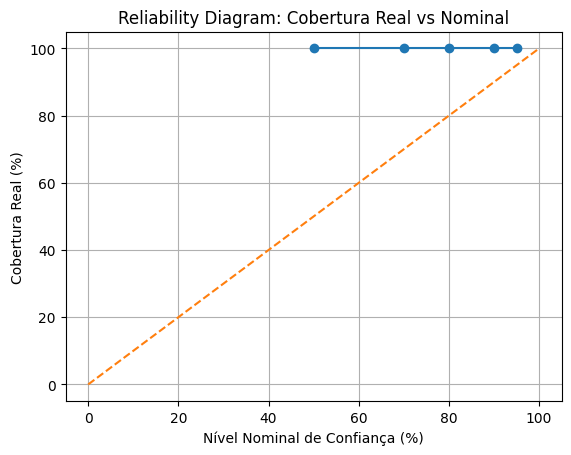

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

# ----- Configurações -----
PRED_PARQ = "datasets/walk_preds.parquet"
TARGET = "slope_kg_per_week"
DATE = "window_start"

# Níveis de confiança e z-scores correspondentes via TFP
levels = [0.50, 0.70, 0.80, 0.90, 0.95]
zs = [float(tfp.distributions.Normal(0., 1.).quantile((1 + lvl) / 2).numpy()) for lvl in levels]

# ----- Carrega predições -----
df = pd.read_parquet(PRED_PARQ)

# Recupera desvio-padrão implícito de IC95
Z95 = zs[-1]
df["pred_sd"] = (df["pred_hi95"] - df["pred_mean"]) / Z95

# ----- Calcula cobertura para cada nível -----
coverage = []
for lvl, z in zip(levels, zs):
    lo = df["pred_mean"] - z * df["pred_sd"]
    hi = df["pred_mean"] + z * df["pred_sd"]
    cover_rate = np.mean((df["slope_real"] >= lo) & (df["slope_real"] <= hi))
    coverage.append(cover_rate)

# ----- Plot Reliability Diagram -----
plt.figure()
plt.plot([lvl * 100 for lvl in levels], [c * 100 for c in coverage], marker="o", linestyle="-")
plt.plot([0, 100], [0, 100], linestyle="--")  # linha de referência
plt.xlabel("Nível Nominal de Confiança (%)")
plt.ylabel("Cobertura Real (%)")
plt.title("Reliability Diagram: Cobertura Real vs Nominal")
plt.grid(True)
plt.show()
